# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Данные

In [ ]:
# !unzip data.zip
# !pip install --upgrade scikit-learn
# !pip install catboost

In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector, ColumnTransformer
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier

PATH_TO_DATA = 'data'
# PATH_TO_DATA = '../input/churn-prediction-spec'

In [2]:
df = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_data.train'))
y = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_labels.train'), header=None, squeeze=True)

In [3]:
nan_cols = df.columns[df.isna().all()]
df.drop(nan_cols, axis=1, inplace=True)

In [4]:
# cat_cols = df.select_dtypes(include='object').columns
# df[cat_cols] = df[cat_cols].astype('category')

In [5]:
df_train, df_ho, y_train, y_valid = train_test_split(df, y, test_size=5000)

In [6]:
class DataFramer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        super().__init__()
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X, columns=self.columns)

In [7]:
numeric_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = Pipeline([
#     ('nan_columns_dropper', NanColumnsDropper()),
    ('preprocessor', preprocessor),
#     ('scaler', StandardScaler()),
    ('to_dataframe', DataFramer(df.columns))
])

X_train = preprocessor_pipeline.fit_transform(df_train)
X_valid = preprocessor_pipeline.transform(df_ho)
X_train

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,-0.034906,0.0,-0.01488,-0.020165,-0.058719,-0.309532,-1.147187,-0.035769,-0.064389,-0.031925,...,Tvpip6Z,zCkv,hHJsvbM,LM8l689qOp,4n2X,ELof,WqMG,6fzt,F2FcTt7IdMT_v,am7c
1,-0.034906,0.0,-0.01488,-0.020165,-0.058719,-0.455378,-1.147187,-0.035769,-0.064389,-0.031925,...,YTCRPlm,oslk,nXK9h3w,LM8l689qOp,4n2X,ELof,453m,RAYp,F2FyR07IdsN7I,am7c
2,-0.034906,0.0,-0.01488,-0.020165,-0.058719,-0.223104,0.029794,-0.035769,-0.064389,-0.031925,...,KhWT_66,oslk,0MplRwa,LM8l689qOp,4n2X,ELof,FSa2,RAYp,F2FyR07IdsN7I,am7c
3,-0.034906,0.0,-0.01488,-0.020165,-0.058719,-0.182591,-1.147187,-0.035769,-0.064389,-0.031925,...,UF10FxM,oslk,BlJqCcD,jySVZNlOJy,4n2X,ELof,me1d,RAYp,55YFVY9,mj86
4,-0.034906,0.0,-0.01488,-0.020165,-0.058719,-0.344643,-1.147187,-0.035769,-0.064389,-0.031925,...,oatfGrO,oslk,8vXEsaq,LM8l689qOp,4n2X,ELof,7P5s,RAYp,F2FyR07IdsN7I,am7c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,-0.034906,0.0,-0.01488,-0.020165,-0.058719,-0.455378,0.029794,-0.035769,-0.064389,-0.031925,...,oPZw9qN,Al6ZaUT,oIW9GgB,LM8l689qOp,4n2X,ELof,szEZ,02N6s8f,F2FyR07IdsN7I,am7c
34996,-0.034906,0.0,-0.01488,-0.020165,-0.058719,1.562161,1.206775,-0.035769,-0.064389,-0.031925,...,4UxGlow,zCkv,catzS2D,LM8l689qOp,4n2X,ELof,PM2D,ZI9m,TCU50_Yjmm6GIBZ0lL_,am7c
34997,-0.034906,0.0,-0.01488,-0.020165,-0.058719,-0.104267,1.206775,-0.035769,-0.064389,-0.031925,...,KA3C5vH,oslk,m1BWuMy,LM8l689qOp,4n2X,ELof,WqMG,RAYp,F2FyR07IdsN7I,am7c
34998,-0.034906,0.0,-0.01488,-0.020165,-0.058719,0.157716,0.029794,-0.035769,-0.064389,-0.031925,...,J8TK3rj,oslk,6ZAHToS,LM8l689qOp,4n2X,ELof,Qu4f,RAYp,F2FyR07IdsN7I,mj86


## Модель

In [10]:
cv = StratifiedShuffleSplit(n_splits=8, random_state=2179)

In [11]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    random_seed=2179
)

# model = LogisticRegression(
#     solver='liblinear',
#     random_state=2179
# )

In [12]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

Learning rate set to 0.388375
0:	learn: 0.3927906	total: 92.8ms	remaining: 9.19s
1:	learn: 0.3009245	total: 140ms	remaining: 6.88s
2:	learn: 0.2700691	total: 153ms	remaining: 4.95s
3:	learn: 0.2586001	total: 183ms	remaining: 4.39s
4:	learn: 0.2540830	total: 208ms	remaining: 3.96s
5:	learn: 0.2480534	total: 250ms	remaining: 3.92s
6:	learn: 0.2464869	total: 280ms	remaining: 3.72s
7:	learn: 0.2438972	total: 307ms	remaining: 3.53s
8:	learn: 0.2424906	total: 332ms	remaining: 3.36s
9:	learn: 0.2409054	total: 357ms	remaining: 3.21s
10:	learn: 0.2397668	total: 379ms	remaining: 3.07s
11:	learn: 0.2393237	total: 402ms	remaining: 2.94s
12:	learn: 0.2392961	total: 413ms	remaining: 2.76s
13:	learn: 0.2387134	total: 435ms	remaining: 2.67s
14:	learn: 0.2385247	total: 456ms	remaining: 2.58s
15:	learn: 0.2385005	total: 465ms	remaining: 2.44s
16:	learn: 0.2380964	total: 486ms	remaining: 2.37s
17:	learn: 0.2377430	total: 509ms	remaining: 2.32s
18:	learn: 0.2370515	total: 531ms	remaining: 2.26s
19:	learn:

In [13]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179
)

pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [14]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc',
                         error_score='raise')
print(scores, '\n', scores.mean())

[0.69302746 0.73364837 0.74197153 0.72363843 0.7210935  0.69658257
 0.72000787 0.73028422] 
 0.7200317437490864
CPU times: user 1.04 s, sys: 321 ms, total: 1.36 s
Wall time: 32.2 s


In [ ]:
# %%time
# gb_classifier = GradientBoostingClassifier(random_state=2179)
# gb_classifier.fit(X_train, y_train)
# print(roc_auc_score(y_valid, gb_classifier.predict_proba(X_valid)[:, 1]))

|Модель|ho ROC AUC|cv ROC AUC|
|-|-|-|
|CatBoost|0.7413546342506111|0.7360205959164293|
|LogisticRegression|0.6523649873142443|0.6725584639126306|

# Инструкции

## 1. Learning curve

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [ ]:
from sklearn.model_selection import  learning_curve

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 8)
import seaborn as sns
sns.set()

In [ ]:
%%time
train_sizes_abs, train_scores, test_scores, fit_times, score_times = learning_curve(
    estimator=model, # catboost
    X=X_train,
    y=y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    return_times=True
)

CPU times: user 13.5 s, sys: 3.4 s, total: 16.9 s
Wall time: 2min 8s


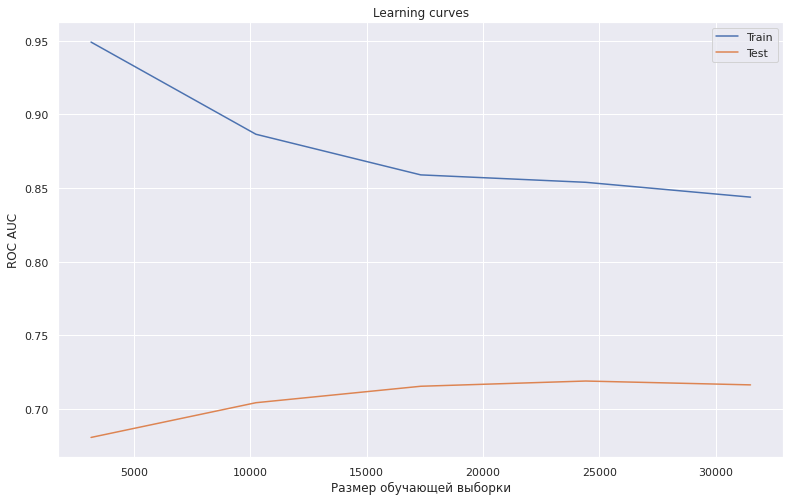

In [ ]:
plt.plot(train_sizes_abs, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes_abs, test_scores.mean(axis=1), label='Test')
plt.legend()
plt.xlabel('Размер обучающей выборки')
plt.ylabel('ROC AUC')
plt.title('Learning curves');

## 2. Balancing

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

### 2.1 Веса

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [18]:
y_train.value_counts()[1] / y_train.value_counts()[-1], y_train.value_counts()[-1] / y_train.value_counts()[1]

(0.08038029386343994, 12.440860215053764)

In [51]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179,
#     auto_class_weights='SqrtBalanced',
    scale_pos_weight=0.08
)

pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [52]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.7272004907017593
CPU times: user 22.6 s, sys: 3.1 s, total: 25.7 s
Wall time: 3.25 s


In [53]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())

[0.73042142 0.73246617 0.76094136 0.7531529  0.74972816 0.75191952
 0.72050214 0.73538224] 
 0.7418142361111111
CPU times: user 781 ms, sys: 75.2 ms, total: 856 ms
Wall time: 29.5 s


|parameter|hold out ROC AUC|cv ROC AUC|
|-|-|-|
|no|0.7413546342506111|0.7360205959164293|
|auto_class_weights='Balanced'|0.7064833272924973|0.7140111585944919|
|auto_class_weights='SqrtBalanced'|0.7036220620626203|0.7237520773979107|
|scale_pos_weight=12|0.6873611769407347|0.7186974715099714|
|scale_pos_weight=0.08|0.7272004907017593|0.7418142361111111|

### 2.2 Undersampling

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [54]:
import random

In [65]:
THRESH = 75

df_train_n_churn = df_train[y_train == -1]
df_train_undersampling = pd.concat([df_train_n_churn.dropna(thresh=THRESH), df_train[y_train == 1]])

X_train_undersampling = preprocessor_pipeline.fit_transform(df_train_undersampling)
X_train_undersampling = pd.DataFrame(X_train_undersampling, columns=df.columns)

In [75]:
SIZE = 20000

sample = random.sample(df_train_n_churn.index.to_list(), SIZE)

df_train_undersampling = pd.concat([df_train_n_churn.loc[sample], df_train[y_train == 1]])

X_train_undersampling = preprocessor_pipeline.fit_transform(df_train_undersampling)
X_train_undersampling = pd.DataFrame(X_train_undersampling, columns=df.columns)

In [61]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179,
    scale_pos_weight=0.08
)

In [76]:
%%time
model.fit(X_train_undersampling, y_train[df_train_undersampling.index])
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.7255624947723534
CPU times: user 17.7 s, sys: 2.06 s, total: 19.8 s
Wall time: 2.5 s


|threshold|ho ROC AUC|
|-|-|
|70|0.6625795183130269|
|73|0.6477388105129134|
|75|0.6170019911524985|

|size|ho ROC AUC|
|-|-|
|32395|0.7316768083010381|
|30000|0.735964349773701|
|25000|0.7286578423992341|
|20000|0.7255624947723534|

## 3. Признаки

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [77]:
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import roc_auc_score

In [78]:
cv = StratifiedShuffleSplit(n_splits=8, random_state=2179)

Стратегия 1: замена на самое частое значение

In [91]:
numeric_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    # ('ordinal_encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = Pipeline([
#     ('nan_columns_dropper', NanColumnsDropper()),
    ('preprocessor', preprocessor),
    # ('scaler', StandardScaler())
    ('to_dataframe', DataFramer(df.columns))
])

In [92]:
%%time
X_train = preprocessor_pipeline.fit_transform(df_train)
X_valid = preprocessor_pipeline.transform(df_ho)
X_train

CPU times: user 603 ms, sys: 279 ms, total: 882 ms
Wall time: 894 ms


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,0.0,0.0,-0.0,0.0,0.0,-0.43775,-1.144028,-0.0,-0.0,0.0,...,fgzCsbI,Al6ZaUT,p2s4IB0,LM8l689qOp,4n2X,ELof,xb3V,02N6s8f,R4y5gQQWY8OodqDV,am7c
1,0.0,0.0,-0.0,0.0,0.0,-0.124917,0.034159,-0.0,-0.0,0.0,...,9WbYE38,oslk,ZI_Qhib,LM8l689qOp,4n2X,ELof,7FJQ,RAYp,TCU50_Yjmm6GIBZ0lL_,am7c
2,0.0,0.0,-0.0,0.0,0.0,0.603077,0.034159,-0.0,-0.0,0.0,...,CWefR8o,oslk,_8WEKx8,LM8l689qOp,4n2X,ELof,Qu4f,RAYp,F2FyR07IdsN7I,am7c
3,0.0,0.0,-0.0,0.0,0.0,-0.496224,-1.144028,-0.0,-0.0,0.0,...,FonmS85,oslk,PC0a_vf,LM8l689qOp,4n2X,ELof,5Acm,RAYp,55YFVY9,am7c
4,0.0,0.0,-0.0,0.0,0.0,-0.078138,1.212347,-0.0,-0.0,0.0,...,kM3Ojel,oslk,20HE4Qn,LM8l689qOp,4n2X,kG3k,Xa3G,RAYp,F2FyR07IdsN7I,am7c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,0.0,0.0,-0.0,0.0,0.0,-0.157078,-1.144028,-0.0,-0.0,0.0,...,Dw7YjZW,oslk,oCzEVaf,LM8l689qOp,4n2X,ELof,FSa2,RAYp,F2FyR07IdsN7I,am7c
34996,0.0,0.0,-0.0,0.0,0.0,0.375031,0.034159,-0.0,-0.0,0.0,...,8_rAQQR,oslk,rT1IXkw,LM8l689qOp,4n2X,ELof,szEZ,RAYp,F2FyR07IdsN7I,am7c
34997,0.0,0.0,-0.0,0.0,0.0,-0.203856,0.034159,-0.0,-0.0,0.0,...,fabfGrO,oslk,TT_zF_Q,LM8l689qOp,4n2X,ELof,szEZ,RAYp,F2FyR07IdsN7I,am7c
34998,0.995947,0.0,-0.0,0.0,0.0,0.0,0.0,13.030477,-0.0,0.0,...,U8I9Iah,oslk,5i2a5gA,LM8l689qOp,4n2X,ELof,FSa2,RAYp,F2FyR07IdsN7I,am7c


In [93]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179
)

pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [94]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.727643098112471
CPU times: user 27 s, sys: 3.23 s, total: 30.2 s
Wall time: 3.62 s


In [95]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc', 
                         error_score='raise')
print(scores, '\n', scores.mean())

[0.73711538 0.72188272 0.77223765 0.75138295 0.75252849 0.76614435
 0.72148267 0.74505461] 
 0.7459786028015195
CPU times: user 787 ms, sys: 69 ms, total: 856 ms
Wall time: 34.2 s


|method num|method cat|ho ROC AUC|cv ROC AUC|
|-|-|-|-|
|most_frequent|most_frequent|0.7413546342506111|0.7360205959164293|
|mean|most_frequent|0.727643098112471|0.7459786028015195|
|median|most_frequent|0.7243560701108726|0.7375290835707502|

## 4. Categorical encoding

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [133]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        dict_ = {}
        self.cat_cols = X.select_dtypes('object').columns
        for col in self.cat_cols:
            dict_[col] = X.groupby(col).size() / len(X)
        self.fe = dict_
        return self

    def transform(self, X, y=None):
        X[self.cat_cols] = X[self.cat_cols].apply(lambda col: col.map(self.fe[col.name]))
        return X

In [134]:
%%time
numeric_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
#     ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ('to_dataframe', DataFramer(df.columns)),
    ('frequency_encoder', FrequencyEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = Pipeline([
#     ('nan_columns_dropper', NanColumnsDropper()),
    ('preprocessor', preprocessor),
#     ('scaler', StandardScaler()),
    ('to_dataframe', DataFramer(df.columns))
])

X_train = preprocessor_pipeline.fit_transform(df_train)
X_valid = preprocessor_pipeline.transform(df_ho)
X_train

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'r__I'

In [154]:
preprocessor_pipeline['preprocessor'].transformers_[1][1][2].cat_cols

AttributeError: 'FrequencyEncoder' object has no attribute 'cat_cols'

In [104]:
dict_ = {}
for col in tmp.columns:
    dict_[col] = tmp.groupby(col).size() / len(tmp)

In [105]:
dict_

{'Var191': Var191
 r__I    1.0
 dtype: float64,
 'Var192': Var192
 0G9vyxdMWg    0.000029
 0kQTmBU3gb    0.000029
 0kQqrQsiZt    0.000029
 0vimfo8zhV    0.006743
 1GdOj17ejg    0.005771
                 ...   
 zKnr4RXktW    0.007257
 zKnrjIPxRp    0.000029
 zcROj17IEC    0.006000
 zcROj1KVEH    0.001543
 zcRZptzip9    0.004829
 Length: 346, dtype: float64,
 'Var193': Var193
 2Knk1KF                                     0.145314
 2wnefc9ISdLjfQoAYBI                         0.000114
 5QKIjwyXr4MCZTEp7uAkS8PtBLcn                0.001286
 8kO9LslBGNXoLvWEuN6tPuN59TdYxfL9Sm6oU       0.000171
 9U2tunPAje3TwfLLUQxzM3dC1ghn                0.000057
 AERks4l                                     0.043943
 B2T7ZTgOX7xpBPBD28SLvVWgBkc13Sm0a3tk2       0.000029
 BrRu5UxtiQY9TTJ8ABKpfS                      0.000400
 ByQdnLRlFnny2k4AJzG                         0.001771
 DH86UFkz9LK6My0ezUgZx96oI                   0.000029
 Fveq5yuDUj6drSMiZO3mXe                      0.000429
 GpoBynXzkxADI7bZBtqvX2IPV5t

In [106]:
tmp.apply(lambda col: col.map(dict_[col.name]))

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,1.0,0.004143,0.010486,0.995629,0.959,0.9914,0.094200,0.015314,0.000143,0.512286,...,0.015314,0.124543,0.015314,0.836457,1.0,0.745571,0.084857,0.068457,0.017086,0.804371
1,1.0,0.006029,0.719771,0.995629,0.959,0.9914,0.005143,0.002057,0.000343,0.512286,...,0.002057,0.739314,0.002057,0.836457,1.0,0.745571,0.044029,0.702257,0.655000,0.804371
2,1.0,0.003314,0.719771,0.995629,0.959,0.9914,0.094200,0.000371,0.004486,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.161229,0.702257,0.655000,0.804371
3,1.0,0.001257,0.145314,0.995629,0.959,0.9914,0.088886,0.001171,0.003229,0.000286,...,0.001171,0.739314,0.001171,0.119943,1.0,0.745571,0.024257,0.702257,0.086114,0.194086
4,1.0,0.003743,0.719771,0.995629,0.959,0.9914,0.088886,0.001000,0.001229,0.512286,...,0.001000,0.739314,0.001000,0.836457,1.0,0.745571,0.055914,0.702257,0.655000,0.804371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,1.0,0.006657,0.719771,0.995629,0.959,0.9914,0.007857,0.000057,0.002343,0.512286,...,0.000057,0.033857,0.000057,0.836457,1.0,0.745571,0.058914,0.047771,0.655000,0.804371
34996,1.0,0.003714,0.145314,0.995629,0.959,0.9914,0.039857,0.089000,0.009200,0.000029,...,0.089000,0.124543,0.089000,0.836457,1.0,0.745571,0.028086,0.122857,0.025400,0.804371
34997,1.0,0.005057,0.719771,0.995629,0.959,0.9914,0.000314,0.000371,0.013114,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.084857,0.702257,0.655000,0.804371
34998,1.0,0.006000,0.719771,0.995629,0.959,0.9914,0.003857,0.000857,0.001000,0.000057,...,0.000857,0.739314,0.000857,0.836457,1.0,0.745571,0.098600,0.702257,0.655000,0.194086


In [99]:
tmp.apply(lambda col: tmp.groupby(col.name).size() / len(tmp))

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
000J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00ARusu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.001029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00AYONy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzfHvGh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzfLM_S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzfUfAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzfo6HG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
tmp.apply(lambda col: col.map(tmp.groupby(col.name).size() / len(tmp)))

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,1.0,0.004143,0.010486,0.995629,0.959,0.9914,0.094200,0.015314,0.000143,0.512286,...,0.015314,0.124543,0.015314,0.836457,1.0,0.745571,0.084857,0.068457,0.017086,0.804371
1,1.0,0.006029,0.719771,0.995629,0.959,0.9914,0.005143,0.002057,0.000343,0.512286,...,0.002057,0.739314,0.002057,0.836457,1.0,0.745571,0.044029,0.702257,0.655000,0.804371
2,1.0,0.003314,0.719771,0.995629,0.959,0.9914,0.094200,0.000371,0.004486,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.161229,0.702257,0.655000,0.804371
3,1.0,0.001257,0.145314,0.995629,0.959,0.9914,0.088886,0.001171,0.003229,0.000286,...,0.001171,0.739314,0.001171,0.119943,1.0,0.745571,0.024257,0.702257,0.086114,0.194086
4,1.0,0.003743,0.719771,0.995629,0.959,0.9914,0.088886,0.001000,0.001229,0.512286,...,0.001000,0.739314,0.001000,0.836457,1.0,0.745571,0.055914,0.702257,0.655000,0.804371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,1.0,0.006657,0.719771,0.995629,0.959,0.9914,0.007857,0.000057,0.002343,0.512286,...,0.000057,0.033857,0.000057,0.836457,1.0,0.745571,0.058914,0.047771,0.655000,0.804371
34996,1.0,0.003714,0.145314,0.995629,0.959,0.9914,0.039857,0.089000,0.009200,0.000029,...,0.089000,0.124543,0.089000,0.836457,1.0,0.745571,0.028086,0.122857,0.025400,0.804371
34997,1.0,0.005057,0.719771,0.995629,0.959,0.9914,0.000314,0.000371,0.013114,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.084857,0.702257,0.655000,0.804371
34998,1.0,0.006000,0.719771,0.995629,0.959,0.9914,0.003857,0.000857,0.001000,0.000057,...,0.000857,0.739314,0.000857,0.836457,1.0,0.745571,0.098600,0.702257,0.655000,0.194086


In [27]:
# model = CatBoostClassifier(
#     max_depth=6, 
#     n_estimators=100, 
#     cat_features=df_train.select_dtypes(include='object').columns.to_list(),
#     logging_level='Silent',
#     one_hot_max_size=2
# )

model = LogisticRegression(random_state=2179)

pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [28]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6261950605679286
CPU times: user 25.3 s, sys: 371 ms, total: 25.7 s
Wall time: 3.32 s


In [29]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc', 
                         error_score='raise')
print(scores, '\n', scores.mean())

[0.64029016 0.62795218 0.64354941 0.63887095 0.62355544 0.60999628
 0.60809731 0.62896355] 
 0.627659408314434
CPU times: user 2.29 s, sys: 141 ms, total: 2.43 s
Wall time: 8.67 s


|model|method|ho ROC AUC|cv ROC AUC|
|-|-|-|-|
|CatBoostClassifier|one_hot_max_size=2|0.7495747310914603|0.7238648100650569|
|CatBoostClassifier|one_hot_max_size=100|0.7473075616276679|0.7253192386638854|
|LogisticRegression|OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)|0.6807580466653527|0.6522513838530051|
|LogisticRegression|OneHotEncoder(handle_unknown='ignore')|0.6261950605679286|0.627659408314434|

## 5. Отбор признаков

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

## 6. Подбор гиперпараметров

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

## 7. Важность признаков

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

# Тест

In [ ]:
def write_to_submission_file(predicted_labels, out_file,
                             target='result', index_label="id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_test_data.csv'), index_col=0)
df_test

In [ ]:
%%time
X_test = preprocessor_pipeline.fit_transform(df_test)
X_test = pd.DataFrame(X_test, columns=preprocessor_pipeline['nan_columns_dropper'].cols)#.astype('int')
X_test

In [ ]:
%%time
# catboost_classifier.fit(X_train_all, y)
prediction = catboost_classifier.predict_proba(X_test)

In [ ]:
write_to_submission_file(prediction[:, 1], 'result.csv')